In [1]:
using AutomotiveDrivingModels
using AutoViz
using AutoScenes
using Records
using PGFPlots
using Parameters

include("../AutoMobius/AutoMobius.jl")
using AutoMobius

include("../crit_cluster_sampling/sample_factor_graph_with_criticality.jl")

include("../clustering/clustering.jl")
"DONE"

"DONE"

### Data for the Clusters

In [2]:
tic()
dicts = load_collision_scenarios()
toc()
length(dicts.list_records)

elapsed time: 12.049633642 seconds


2000

In [3]:
crit_entries = load_crit_entries()
clusters = map_cluster_names_to_indices(crit_entries)

for (s,inds) in clusters
    println(s, " => ", length(inds), " critical entries")
end

LLR1 => 5 critical entries
R1 => 450 critical entries
LR1 => 1537 critical entries
LLL0 => 8 critical entries


In [4]:
risk_threshold = 0.5
crit_scenes = load_crit_scenes(crit_entries, risk_threshold=risk_threshold);

In [5]:
speed_lo = Inf
speed_hi = -Inf
for scene in crit_scenes
    for veh in scene
        speed_lo = min(speed_lo, veh.state.v)
        speed_hi = max(speed_hi, veh.state.v)
    end
end
(speed_lo, speed_hi)

(-0.5744683486484573, 40.75209574540072)

### Load Factor Graphs

In [21]:
clusterids = ["R1", "LR1"]
models = Dict{String, FactorModel}()
for clusterid in clusterids
    model = @AutoScenes.load_factor_model("../data/1d_factorgraph_model_with_criticality_$clusterid.txt")
    model = create_penalty_model_from_global(model)
    models[clusterid] = model
end
"DONE"

"DONE"

In [12]:
mutable struct CriticalCarOverlay <: SceneOverlay
    target_id::Int
end
function AutoViz.render!(rendermodel::RenderModel, overlay::CriticalCarOverlay, scene::MobiusScene, roadway::MobiusRoadway)
    ind = findfirst(scene, overlay.target_id)
    if ind > 0
        veh = scene[ind]
        pts = Matrix{Float64}(2,2)
        pts[1,:] = veh.state.s
        pts[2,1] = -12
        pts[2,2] = -5
        add_instruction!(rendermodel, render_arrow, (pts, colorant"white", 0.25, 3.0))
    end
    return rendermodel
end

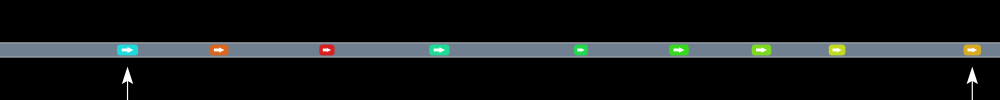

In [15]:
srand(0)
timestep = 0.1
behgen = ErrorableIDMBehaviorGenerator(timestep)

scene_index = 1
scene = crit_scenes[scene_index]

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
car_colors = get_pastel_car_colors(scene)
render(scene, roadway, SceneOverlay[CriticalCarOverlay(dicts.crit_rears[crit_entries[scene_index].key]),
                                    CriticalCarOverlay(dicts.crit_fores[crit_entries[scene_index].key])],
       cam=cam, canvas_height=100, car_colors=car_colors)

In [27]:
cluster_factorgraphs = Dict{String, Vector{FactorGraph}}()
tic()
for clusterid in clusterids
    features = models[clusterid].features
    factorgraphs = [get_factorgraph(crit_scenes[scene_index], roadway, get_crit_cars(dicts, crit_entries, scene_index), features)
                    for scene_index in 1:length(crit_scenes) if crit_entries[scene_index].assignment == clusterid]
    cluster_factorgraphs[clusterid] = factorgraphs
end
toc()

elapsed time: 3.444145944 seconds


3.444145944

In [29]:
gens = Dict{String, FactorGraphSceneGenerator}()
for clusterid in clusterids
    gens[clusterid] = FactorGraphSceneGenerator(models[clusterid], Dict(:s => Normal(0.0,5.0), :v => Normal(0.0,1.0)), 1000)
end
"DONE"

"DONE"

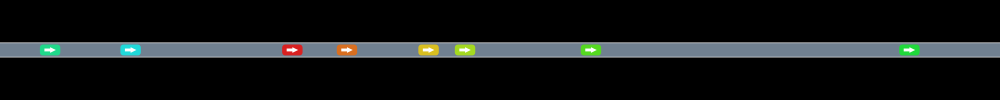

In [15]:
scene2 = shift_scene!(MobiusScene(), Δ, factorgraph)
render(scene2, roadway, cam=cam, canvas_height=100, car_colors=car_colors)

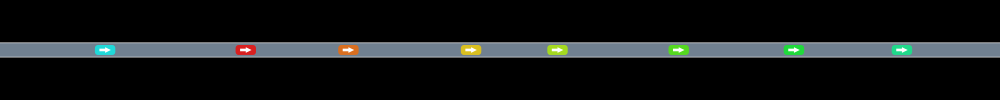

In [16]:
render(scenes[1], roadway, cam=cam, canvas_height=100, car_colors=car_colors)

# sample a dataset

In [21]:
using StatsBase

gen = FactorGraphSceneGenerator(model, Dict(:s => Normal(0.0,5.0), :v => Normal(0.0,1.0)), 1000)

srand(0)
m = 1000
frames = Array{MobiusScene}(m)
critical_cars_out = Vector{Vector{Int}}(m)
for i in 1 : m
    j = rand(1:length(scenes))
    Δ = metropolis_hastings!(gen, factorgraphs[j])
    frames[i] = shift_scene!(MobiusScene(), Δ, factorgraphs[j])
    critical_cars_out[i] = critical_cars[j]
end

"done"

"done"

In [23]:
open("../data/scenes_attentivemobiusfactorgraph_0731.txt", "w") do io
    write(io, MIME"text/plain"(), frames)
end
open("../data/crit_cars_attentivemobiusfactorgraph_0731.txt", "w") do io
    println(io, length(critical_cars_out))
    for crit_cars in critical_cars_out
        for (i,v) in enumerate(crit_cars)
            print(io, v, i == length(crit_cars) ? "\n" : " ")
        end
    end
end
"DONE"

"DONE"

In [30]:
# open("../data/scenes_attentivemobiusfactorgraph_0728.txt") do io
#     read(io, MIME"text/plain"(), Vector{MobiusScene})
# end
"DONE"

1000-element Array{Records.Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}},1}:
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(10 entities)
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(8 entities) 
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(9 entities) 
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(24 entities)
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(9 entities) 
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(9 entities) 
 Frame{Records.Entity{AutomotiveDrivingModels.PosSpeed1D,AutomotiveDrivingModels.BoundingBoxDef,Int64}}(10 entities)
 Frame{Records.Entity{AutomotiveDrivingModels.P